# Simulación de un modelo fermiónico con Qiskit

En este proyecto abordaremos la simulación de sistemas fermiónicos a través de un procesador cuántico digital. En particular, consideraremos el celebrado **Hamiltoniano de Hubbard**, de gran utilidad en la física del estado sólido. Para ello, realizaremos una breve introducción sobre la naturaleza física de los fermiones, así como las herramientas matemáticas que permiten representar un sistema de varias de estas partículas correlacionadas. Posteriormente, consideraremos la forma general de un Hamiltoniano de Hubbard, apuntando a la interpretación física general de sus partes.

Con este concimiento previo, procederemos a abordar el problema de simular un sistema fermiónico descrito por el Hamiltoniano de Hubbard con un procesador cuántico digital. Introduciremos la **transformación de Jordan-Wigner (JWT)** y presentaremos una posible forma de utilizarla para mapear el Hamiltoniano fermiónico a un Hamiltoniano de qubits. Finalmente, presentaremos el algoritmo de simulación propuesto por **Barends et. al.** para estudiar la evolución temporal de un par de modos fermiónicos interactuantes. Con este proyecto esperamos ilustrar una de las aplicaciones más prometedoras de la computación cuánticas: la simulación de sistemas físicos.

**NOTA:** Este artículo puede ser un poco exigente para el lector con poca experiencia en mecánica cuántica. Sin embargo, intentaremos condensar las ideas físicas fundamentales.

## Introducción

Tal vez por medio de alguna publicación en divulgación científica o curiosidad propia, el lector habrña escuchado sobre la distinción entre bosones y fermiones. Usualmente se identifica a los bosones como las partículas mediadoras de fuerzas, mientras que los fermiones se asocian a las partículas de materia. Sin embargo, la distinción fundamental entre estos dos tipos radica en la forma como se describen los denominados *sistemas de varios cuerpos*. Tanto los bosones como los fermiones son indistinguibles, es decir, no hay forma de separar un bosón o fermión de otro.

> A diferencia de los bosones, los fermiones obedecen el principio de exclusión de Pauli. Esto significa que no es posible que dos fermiones tengan el mismo estado cuántico al tiempo.

Para entender esto un poco mejor, acudiremos a la representación de Fock de la mecánica cuántica. Aunque puede parecer un poco extraña en un principio, consideramos que es una forma más natural de entender la diferencia entre fermiones y bosones.

### Fermiones en el espacio de Fock

Imaginemos un físico que ingresa a su primer día de trabajo en el laboratorio. El gerente de laboratorios le indica que los osciloscopios se encuentran en la repisa de la esquina superior izquierda de la puerta de entrada. Las tomas de corriente se ubican en la pared de la derecha, a 2 pasos del escritorio. El horno y la estación de soldadura se encuentran en la pared del fondo, a unos 12 metros de la entrada. En un primer momento, el físico realiza una **descripción espacial** de su laboratorio, identificando el estado de las herramientas del laboratorio por su ubicación con respecto a un punto de referencia del mismo.

Sin embargo, al poco tiempo, el físico nota que las tomas de corriente, las repisas, el escritorio, la puerta y las ventanas siempre mantienen una distribución especial particular. Los elementos de su laboratorio no necesitan describirse en términos de la localización espacial, sino más bien de si alguna de sus repisas, mesas o cajones esta ocupada por una herramienta o no. Así, por ejemplo, si el físico informa que las resistencias eléctricas se han acabado, no dirá "*el cajón que se encuentra a 2 pasos a la izquierda de mi escritorio, sobre las tomas de corriente, está vacío*". En su lugar afirmará que *el cajón de las resistencias está vacío*. ¿Y qué tiene esto que ver con los quarks, fotones, electrones y demás partículas?

En física cuántica, es conocido que todos los posibles estados de posición de una partícula pueden representarse por medio de un *conjunto discreto* que genericamente llamaremos **orbitales espaciales**. Típicamente, estudiamos partículas de espín 1/2, que pueden describirse por dos estados de espín. Al combinar los estados de posición con los estados de espín podemos generar todos los posibles estados de una partícula utilizando una base discreta conocida como **espín orbitales**.

> Los espín orbitales son como las repisas, cajones y mesas en el laboratorio del físico, mientras que los electrones son como las herramientas. Cuando un físico intuye la simetría de un sistema de varias partículas, resulta más fácil proponer un conjunto de espín orbitales y definir el estado global observando si una de las partículas está ocupando un determinado orbital.

Presentamos un ejemplo visual sobre la forma como podemos describir el estado de un sistema de varios fermiones en el espacio de Fock. Cada espín orbital se representa por $|\chi_i\rangle$. Consideraremos una base de 4 orbitales, y un sistema de 2 partículas.

<p align="center">
    <img src="HubbardWithQiskit_files/FockSpaceDemo.png" height="500" width="700">
</p>

Para un conjunto determinado de $M$ espín orbitales, podemos especificar el estado de un sistema de varias partículas diciendo si una partícula se encuentra en un estado descrito por un espín orbital del mismo. En tal caso, diremos que un particular espín orbital *está ocupado*. Estas ideas pueden ser un poco abstractas para aquellos lectores con énfasis en ciencias de la computación. Sin embargo, esperamos que los ejemplos gráficos logren generar una intuición sobre la descripción de un sistema de varias partículas. 

Como apuntamos anteriormente, *el principio de exclusión de Pauli impide que dos fermiones ocupen el mismo orbital*. Es decir, no podemos tener dos fermiones en la misma repisa. Bajo estas condiciones, el estado de un sistema de varios fermiones puede especificarse por medio de una cadena binaria de $M$-bits. Cada bit nos dirá si un particular orbital está ocupado o no. Con esta base de $2^M$ estados podemos construir cualquier estado del sistema aplicando el principio de superposición. Este espacio lo denominaremos **espacio de Fock**.

> En general, la base de espín orbitales tiene un número infinito de elementos. Puesto que en física computacional no tenemos tanto espacio disponible, truncamos la base para que contenga $M$ elementos.

En resumen, describiremos el estado de un sistema de $N$ partículas utilizando una base de $M$ espín orbitales. Representaremos el vector de estado como una superposición de estados que nos diran si un particular espín orbital está ocupado o no. Por tanto, un vector de la base de nuestro espacio de Fock tiene la forma

$$|\psi\rangle = |q_0q_1 \cdots q_{M-1}\rangle \text{ con } q_i = 0,1$$

El lector notará que no todas las cadenas binarias de $M$-bits tienen el mismo número de 1s, así que los estados de la base de nuestro espacio de Fock *no tienen el mismo número de partículas*. No debemos preocuparnos por esto. En nuestra nueva descripción, veremos como crear y aniquilar partículas. Sin embargo, es importante mencionar que los operadores que describen sistemas físicos a bajas energías deben conservar el número de partículas.

**SUPER IMPORTANTE:** El principio de exclusión de Pauli implica que $M \geq N$. Invitamos al lector a convencerse de que esto debe ser así.

### Creación y aniquilación de partículas

¿Cómo podemos distringuir los estados fermiónicos de los estados bosónicos? Si bien sabemos que los estados fermiónicos solo pueden representarse por cadenas binarias, nada impide que un estado bosónico sea representado de esta manera. Sin embargo, podemos realizar una distición de los estados de ambos tipos de partículas al realizar una *permutación de partículas*. Anteriomente mencionamos que tanto bosonones como fermiones son *indistinguibles*. Esto significa que el vector de estado de un sistema de partículas idénticas tiene alguna simetría bajo intercambio de un par de sus constituyentes.

> Los estados bosónicos son simétricos bajo el intercambio de partículas, mientras que los estados fermiónicos son antisimétricos bajo esta misma operación. Al intercambiar las partículas $i$ y $j$, el orbital de la $j$-ésima partícula pasa a ser el de la $i$-ésima, y viceversa.

Para "mover" partículas entre orbitales, utilizamos los operadores de **creación y aniquilación**. Estos poblan un orbital, o desparacen una partícula de este. Por convención, definiremos un estado especial, que llamaremos **vacío**. Este estado es aquel en el cual no hay partículas. Como el lector podrá intuir, se representa por la cadena binaria de $M$ ceros. Al aplicar un operador de aniquilación sobre este estado, obtenemos el vector $\vec{0}$ del espacio de Fock en el que estemos trabajando. Así

$$|0_10_2 \cdots 0_M\rangle \equiv |vac\rangle$$

Nos concentraremos en los operadores de creación y aniquilación fermiónicos. Tendremos operadores para crear y aniquilar fermiones en cada espín orbital de una base. Descubriremos relaciones algebráicas entre ellos y finalmente veremos el tipo de operadores que conservan el número de partículas.

#### Operadores de creación

Para describir un sistema de varioas fermiones, utilizaremos un conjunto de $M$ operadores de creación, uno por cada orbital. Denotaremos el operador de creación del $i$-ésimo orbital con $\hat{a}_i$. Incluimos una representación gráfica de lo que nos gustaría que hiciera un operador de creación arbitrario

<p align="center">
    <img src="HubbardWithQiskit_files/Creation.png" height="300" width="450">
</p>

Así que postulamos que la acción de cualquiera de estos operadores sobre cualquier estado base de nuestro espacio de Fock es tal que

$$\hat{a}^{\dagger}_i |q_0 \cdots 1_i \cdots q_{M-1} \rangle = \vec{0}$$
$$\hat{a}^{\dagger}_i |q_0 \cdots 0_i \cdots q_{M-1} \rangle = \Gamma^{\vec{q}}_{i} |q_0 \cdots 1_i \cdots q_{M-1}\rangle$$

Donde la fase

$$\Gamma^{\vec{q}}_{i} = \prod_{k = 0}^{i-1}(-1)^{q_k}$$

Se incluye para darle naturaleza fermiónica a estos operadores. Una motivación más rigurosa para esta definición la veremos en siguientes publicaciones. Por el momento, veremos las implicaciones de esta definición. En primer lugar, apuntamos que cualquier estado base del espacio de Fock puede generarse a partir del estado vacío, por medio de una cadena de operadores de creación. Así

$$| q_0 \cdots q_{M-1} \rangle = |\vec{q} \rangle = \prod_{k = 0}^{M-1} (\hat{a}^{\dagger})^{q_k} |vac\rangle$$

Aunque parezca trivial, lo que esto nos dice es que la naturaleza fermiónica de las partículas está condensada en los operadores de creación y aniquilación. En segundo lugar, invitamos al lector a convencerse de que

$$[\hat{a}^{\dagger}_i, \hat{a}^{\dagger}_j]_{+} = \hat{0}$$

Donde realizamos la definición

$$[\hat{A},\hat{B}]_{+} = \hat{A}\hat{B} + \hat{B}\hat{A}$$

Aunque el lector con fundamentación en física cuántica pueda sentirse un poco frustrado por la definición que hemos planteado de estos operadores, veremos más adelante la utilidad de la misma. Procedemos a discutir la definición de los operadores de aniquilación.

#### Operadores de aniquilación

Por cada operador de creación, tendremos un operador de aniquilación, que denotaremos con $\hat{a}_i$. A continuación ilustramos gráficamente lo que nos gustaría que hiciera un operador de aniquilación

<p align="center">
    <img src="HubbardWithQiskit_files/Anihilation.png" height="300" width="450">
</p>

No hemos utilizado la daga en vano. De hecho, postulamos que $\hat{a}_i = (\hat{a}^{\dagger}_i)^{\dagger}$. Donde la daga indica transpuesto complejo conjugado (i. e. *Hermítico conjugado*). Invitamos al lector a convencerse de que la acción de un operador de aniquilación sobre un estado de la base de nuestro espacio de Fock es

$$\hat{a}_i |q_0 \cdots 1_i \cdots q_{M-1} \rangle =  \Gamma^{\vec{q}}_{i}|q_0 \cdots 0_i \cdots q_{M-1}\rangle$$
$$\hat{a}_i |q_0 \cdots 0_i \cdots q_{M-1} \rangle = \vec{0}$$

Pero no acabamos aquí. Presentaremos algunas propiedades algebráicas de los operadores de creación y aniquilación. En primer lugar, invitamos al lector a convencerse de que

$$\hat{a}_i |vac\rangle = \hat{0}$$

De modo que, como mencionamos anteriomente, el vacío es un estado particular de nuestro espacio de Fock en el cual no tenemos ningún fermión. En general, un operador de aniquilación reduce el número de partículas en el sistema, mientras que un operador de creación, lo aumenta. De ahí sus nombres. Por otro lado, invitamos al lector con cierta experiencia en los terrenos de la física cuántica a convencerse de que

$$[\hat{a}_i, \hat{a}_j]_{+} = \hat{0}$$
$$[\hat{a}^{\dagger}_i, \hat{a}_j]_{+} = \delta_{i,j}$$
$$[\hat{a}^{\dagger}_i,\hat{a}^{\dagger}_j]_{+} = 0$$

Donde $\delta_{i,j}$ es la famosa *delta de Kroenecker*, que es 1 para índices iguales y 0 en otro caso. Las relaciones de anticonmutación anteriores definen el conjunto de operadores de creación y aniquilación fermiónicos. Cualquier conjunto de operadores que satisfagan este conjunto de ecuaciones pueden ser un conjunto de operadores de creación y aniquilación fermiónicos. Esto lo aprovecharemos más adelante para mapear un Hamiltioniano fermiónico a un Hmailtoniano de qubits.

#### Operadores que conservan el número de partículas

Son raras los ocasiones en que fermiones pueden realmente crearse o aniquilarse en un laboratorio. Tal vez en algunos experimentos en física de altas energías. En sistemas como átomos o moléculas, el número total de partículas se conserva. El primer tipo de operadores que conserva el número de partículas es el de **número de ocupación**. Definimos un operador de estos por cada orbital

$$\hat{N}_i = \hat{a}^{\dagger}_i \hat{a}_i$$

Invitamos al lector a convencerse de que

$$\hat{N}_i |\vec{q}\rangle = q_i|\vec{q}\rangle$$

De modo que el nombre es más que justificado. Definimos el operador **número de partículas**

$$\hat{N} = \sum_{i = 0}^{M-1} \hat{N}_i$$

Estos operadores no son tan interesantes, puesto que no describen la energía cinética ni la energía de interacción de las partículas del sistema. Por tanto, definiremos dos tipos más de operadores que conservan el número de partículas. Estos son los denominados **operadores de excitación** y los operadores de **varias partículas**.

Los operadores de excitación permiten "mover" una partícula de un orbital a otro. Representamos gráficamente la acción de un operador de excitación

<p align="center">
    <img src="HubbardWithQiskit_files/Excitation.png" height="300" width="450">
</p>

Definimos matemáticamente estos operadores como

$$\hat{X}^{j}_{i} = \hat{a}^{\dagger}_j \hat{a}_{i}$$

Como ilustra la imagen, estos mueven una partícula del orbital $i$-ésimo al orbital $j$-ésimo. Los operadores de excitación son *operadores de una partícula*. Puden utilizarse para describir un Hamiltoniano desacoplado, en el cual el movimiento de los fermiones de un sistema no es correlacionado. Con ellos podemos describir términos de energía cinética o movimiento en presencia de un centro de fuerzas, pero no podemos describir interacciones entre fermiones. Para ello necesitaremos operadores de *varias partículas*.

Antes de ello, invitamos al lector a convencerse de que cualquier cadena de operadores que tenga el mismo número de operadores de aniquilación que de creación, conserva el número de partículas. Si bien esto es intuitivo, una demostración regurosa hace uso de las relaciones de anticonmutación que hemos presentado, y no la expondremos aquí para no oscurcer la discusión. Así, por ejemplo

$$\hat{Y}^{kl}_{ji} = \hat{a}^{\dagger}_{k}\hat{a}^{\dagger}_{l}\hat{a}_j\hat{a}_i$$

Es un operador que conserva el número de partículas. A partir de la intuición que hemos desarrollado sobre los operadores de creación y aniquilación, vemos que este mezcla 4 orbitales. En particular, este tipo de operadores "mueven" dos partículas. Por tanto, los denominaremos operadores de *dos partículas*. Incluimos una representación pictórica de su acción sobre un sistema de dos fermiones

<p align="center">
    <img src="HubbardWithQiskit_files/TwoFermion.png" height="300" width="450">
</p>

Con ellos podremos describir movimiento correlacionado en un sistema de varios fermiones.

> Los operadores de creación y aniquilación nos permiten describir de forma completa la dinámica de un sistema de varios fermiones. La combinación de operadores de excitación y de varias partículas nos permite construir Hamiltonianos para sistemas complejos en el espacio de Fock.

### El Hamiltoniano tipo Hubbard

Nos encontramos en capacidad de considerar uno de los Hamiltonianos más ampliamente utilizados en el estudo de la física del estado sólido. Podemos imaginar una red de puntos en el espacio, donde cada punto puede ser ocupado por un fermión. Esta red puede corresponder a la estructura cristalina de los átomos de un sólido. Incluimos una representación del sistema a considerar.

<p align="center">
    <img src="HubbardWithQiskit_files/LatticeHubbard.png" height="300" width="450">
</p>

En este caso, nuestros operadores de creación y aniquilación "moveran" partículas entre los distintos puntos de la red. Los vértices de la red representaran centros de potencial. Consideraremos que los fermiones en la red son electrones. Así podremos describir el movimiento correlacionado de electrones y sus efectos en propiedades de conducción de un sólido. Comenzaremos considerando los efectos que tienen los núcleos atómicos en los puntos de red sobre el movimiento de un fermión. Posteriormente, incluiremos los efectos de la repulsión electrónica y otras interacciones de correlación.

#### Movimiento desacoplado

Tanto la energía cinética de un fermión, como su interacción con el potencial local de un punto de red no depende de la ocupación de los otros puntos. Por tanto, podremos representar estas cantidades utilizando operadores de un fermión. Aunque un tanto incorrecto, podemos intuir que un fermión con sufiente energía cinética podría "saltar" de un punto de red a otro. Por tanto, los operadores que describen el movimiento desacoplado son **de excitación**. Supondremos que un fermión solo puede saltar desde un punto de red a sus primeros vecinos

<p align="center">
    <img src="HubbardWithQiskit_files/NearestNeighbours.png" height="300" width="450">
</p>

Así, nuestro Hamiltoniano parcial es

$$\hat{H}_T = -V\sum_{\langle i,j \rangle} (\hat{a}^\dagger_i \hat{a}_j + \hat{a}^\dagger_j \hat{a}_i)$$

Donde $\langle i,j \rangle$ denota **suma sobre primeros vecinos**.

#### Movimiento correlacionado

El movimiento correlacionado es un fenómeno de dos o más electrones un un sólido. Por tanto, debe estar descrito por *operadores de varios fermiones*. Por simplicidad, asumiremos un Hamiltoniano de interacción que depende del número de ocupación entre puntos de red adyacentes. Aunque es un poco arbitrario, asumiremos un Hamiltoniano de la forma

$$\hat{H}_U = U \sum_{\langle i,j \rangle} \hat{a}^{\dagger}_j \hat{a}_j \hat{a}^{\dagger}_i \hat{a}_i$$

**SUPER IMPORTANTE:** En un modelo de Hubbard real, el movimiento correlacionado proviene de la repulsión entre fermiones con espín opuesto. Se realiza una distinción entre operadores de creación y aniquilación de fermionse de espín arriba y de espín abajo. Sin embargo, consideraremos un ejemplo pedagógico en este proyecto.

En suma, nuestro modelo fermiónico simple estará descrito por un Hamiltoniano de la forma

$$\hat{H} = \hat{H}_T + \hat{H}_U = -V\sum_{\langle i,j \rangle} (\hat{a}^\dagger_i \hat{a}_j + \hat{a}^\dagger_j \hat{a}_i) + U \sum_{\langle i,j \rangle} \hat{a}^{\dagger}_j \hat{a}_j \hat{a}^{\dagger}_i \hat{a}_i$$

## Simulación del sistema en un procesador cuántico

Para este proyecto, consideraremos una red de dos puntos, de modo que nuestro Hamiltoniano se simplifica enormemente

$$\hat{H} = -V (\hat{b}^{\dagger}_1 \hat{b}_2 + \hat{b}^{\dagger}_2 \hat{b}_1) + U \hat{b}^{\dagger}_1 \hat{b}_1 \hat{b}^{\dagger}_2 \hat{b}_2$$

Después de la inrtoducción teórica, procederemos a mapear nuestro Hamiltoniano fermiónico a un Hamiltoniano de qubits. Construiremos un circuito para realizar la evolución temporal de acuerdo con la ecuación de Schrödinger. Finalmente, emularemos una evolución temporal utilizando Qiskit.

### Mapeo de Jordan-Wigner (JWT)

Creo que el lector ya habrá intuido que los estados de un sistema de varios qubits se mepaen directamente a los estados de varios fermiones. Incluso, es posible que haya advertido que los operadores

$$\sigma^{+}_i = |1_i \rangle\langle 0_i| = \sigma_x^{(i)} + \mathrm{i}\sigma_y^{(i)}$$
$$\sigma^{-}_i = |0_i \rangle\langle 1_i| = \sigma_x^{(i)} - \mathrm{i}\sigma_y^{(i)}$$

Son similares a los operadores de creación y aniquilación que hemos discutido. Advertimos, sin embargo, que si bien tienen el efecto sobre el cambio de estado, **no producen la fase** $\Gamma^{\vec{q}}_i$. Recordemos que esta fase le da el caracter antisimétrico a una función de onda fermiónica. Para resolver este problema, utilizaremos operadores Z de pauli para determinar la paridad de la cadena. Así, nuestros operadores de creación y aniquilación en un sistema de $M$ qubits serán

$$\hat{a}^{\dagger}_i = (\otimes_{k = 0}^{i-1} \sigma_z^{(k)}) \otimes \sigma_{+}^{(i)}$$
$$\hat{a}_i = (\otimes_{k = 0}^{i-1} \sigma_z^{(k)}) \otimes \sigma_{-}^{(i)}$$

Invitamos al lector a probar que estos operadores satisfacen las relaciones de anticonmutación que los operadores fermiónicos vistos anteriormente. De esta forma, hemos mapeado un conjunto de operadores fermiónicos a un conjunto de operadores de qubits. Esta es la denominada transformación de Jordan-Wigner (JWT).

> Por medio de la transformación de Jordan-Wigner, que es no local, podemos transformar un Hamiltoniano fermiónico a un Hamiltoniano de qubits, identificando la base computacional con la base número de ocupación del espacio de Fock.

**SUPER IMPORTANTE:** La JWT solo transforma Hamiltonianos fermiónicos locales en Hamiltonianos de qubits locales en una dimensión. Local significa que los operadores solo actúan sobre los primeros vecinos de un qubit o fermión. Existen otros mapeos como el de Brayiv-Kitaev o el de paridad que pueden ser más apropiados, pero esto depende del Hamiltoniano.

Para nuestro sistema de 2 puntos de red, la JWT nos dice que los operadores creación son

$$\hat{a}^\dagger_1 = \sigma_{+}^{(1)}$$
$$\hat{a}^\dagger_1 = \sigma_z^{(1)} \otimes \sigma_{+}^{(2)}$$

Invitamos al lector a comprobar que esta tranformación nos produce el siguiente Hamiltoniano de qubits

$$\hat{H} = \frac{V}{2} (\sigma_x^{(1)} \otimes \sigma_x^{(2)} + \sigma_y^{(1)} \otimes \sigma_y^{(2)}) + \frac{U}{4} (\sigma_z^{(1)} \otimes \sigma_z^{(2)} + \sigma_{z}^{(1)} + \sigma_{z}^{(2)})$$

### Evolución temporal

Para simular un sistema físico necesitamos poder realizar evolución temporal. De acuerdo con los postulados de la mecánica cuántica, podemos emular la evolución de neustro sistema fermiónico por medio de un operador

$$\hat{U}(t) = \exp(-\mathrm{i}t\hat{H})$$

En general, implementar un circuito que calcule este operador no es trivial. Sin embargo, podemos realizar una aproximación. Exponenciaremos nuestro Hamiltoniano por partes, siguiendo lo que se denomina un **esquema de Trotter**. Este esquema es más preciso cuanto más pequeño sea el tiempo de simulación

$$\exp(-\mathrm{i}t\hat{H}) \approx \exp(-\mathrm{i}t \frac{V}{2} \sigma_x^{(1)} \otimes \sigma_x^{(2)})\exp(-\mathrm{i}t \frac{V}{2} \sigma_y^{(1)} \otimes \sigma_y^{(2)}) \exp(-\mathrm{i}t \frac{U}{4} \sigma_z^{(1)} \otimes \sigma_z^{(2)})\exp(-\mathrm{i}t \frac{U}{4} \sigma_z^{(1)})\exp(-\mathrm{i}t \frac{U}{4} \sigma_z^{(1)})$$

Invitamos al lector a demostrar que esta aproximación tiene un error de orden $t^2$

### Simulación con Qiskit

Implementaremos un circuito que realice evolución temporal haciendo pasitos pequeños de Trotter. Empezaremos con los operadores sencillos de exponenciar, que son los que dependen de operadores Z de Pauli. Posteriormente, utilizaremos la intuición ganada para exponenciar el resto de operadores.

Primero importamos las librerías correspondientes

In [22]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import Parameter
import numpy as np
import matplotlib.pyplot as plt

#### Simulación de evolución bajo  $\exp(-\mathrm{i}t \frac{U}{4} \sigma_z^{(1)})\exp(-\mathrm{i}t \frac{U}{4} \sigma_z^{(1)})$

Sabemos que necesitaremos un circuito de 2 qubits para simular el sistema fermiónico. Así que procedemos a iniciar un circuito con dos qubits y dos bits

In [46]:
## Registro para simulacion
ferms = QuantumRegister(2,name='f')
## Registro para medicion
res = ClassicalRegister(2,name='r')
## Declaración circuito cuántico
Simula = QuantumCircuit(ferms)

La evolución temporal bajo estos operadores está desacoplada, y corresponde a rotaciones en dirección z, con un ángulo que depende del tiempo. Crearemos los parámetros, definiremos las rotaciones y las incluiremos en el circuito. 

**IMPORTANTE:** Hay que tener cuidado con la convención de rotaciones en computación cuántica.

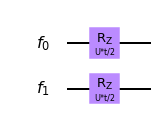

In [47]:
## Integral desacoplada
V = Parameter('V')
## Integral acoplada
U = Parameter('U')
## Tiempo simulacion
t = Parameter('t')
## Añadimos las compuertas de rotación
Simula.rz(U*t/2,ferms[0])
Simula.rz(U*t/2,ferms[1])
## Dibujamos el circuito
Simula.draw(output='mpl')

#### Simulación de evolución bajo $\exp(-\mathrm{i}t \frac{U}{4} \sigma_z^{(1)} \otimes \sigma_z^{(2)})$

Notamos por ahora que este operador tiene una descripción sencilla en la base computacional. Primero, consideremos el operador $\sigma_z^{(1)} \otimes \sigma_z^{(2)}$. Este tiene valor $1$ si los qubits están en el mismo estado, y $-1$, en otro caso. Al exponenciar, ganamos una fase $\exp(\mp \mathrm{i}t \frac{U}{4})$, dependiendo del valor de los qubits en la base computacional. Por tanto, este unitario lo podemos implementar por medio de un par de compuertas CNOT y una rotación sobre el eje z.

**SUPER IMPORTANTE:** Invitamos al lector a comprobar que en efecto esta descripción construye el unitario deseado.

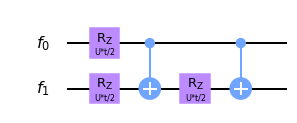

In [48]:
## Utilizamos CNOT para computar XOR Reversible
Simula.cx(ferms[0],ferms[1])
## Empleamos rotación para incluir fase
Simula.rz(U*t/2,ferms[1])
## Dehacemos el cómputo
Simula.cx(ferms[0],ferms[1])
## Dibujamos el circuito
Simula.draw(output='mpl')

#### Simulación de evolución bajo $\exp(-\mathrm{i}t \frac{V}{2} \sigma_x^{(1)} \otimes \sigma_x^{(2)})$

Podemos realizar un cambio de base, que nos lleve de la computacional, a la base del operador X de Pauli. Allí, el circuito que hemos planteado para realizar la evolución temporal con la Z nos seguirá funcionando. Por tanto, solo tendremos que realizar una transformación de Hadamard y repetir el truco anterior para construir este unitario

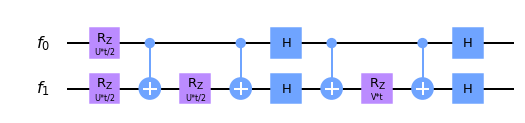

In [49]:
## Transformación de Hadamard
Simula.h(ferms[0])
Simula.h(ferms[1])
## Utilizamos CNOT para computar XOR Reversible
Simula.cx(ferms[0],ferms[1])
## Empleamos rotación para incluir fase
Simula.rz(V*t,ferms[1])
## Dehacemos el cómputo
Simula.cx(ferms[0],ferms[1])
## Transformación de Hadamard
Simula.h(ferms[0])
Simula.h(ferms[1])
## Dibujamos el circuito
Simula.draw(output='mpl')

#### Simulación de evolución bajo $\exp(-\mathrm{i}t \frac{V}{2} \sigma_y^{(1)} \otimes \sigma_y^{(2)})$

Podemos realizar un cambio de base, que nos lleve de la computacional, a la base del operador Y de Pauli. Allí, el circuito que hemos planteado para realizar la evolución temporal con la Z nos seguirá funcionando. Por tanto, solo tendremos que realizar una transformación de Hadamard, agregando una compuerta $S$, y repetir el truco anterior para construir este unitario

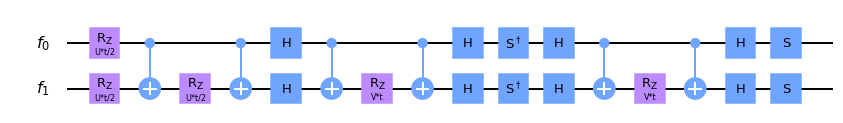

In [50]:
## Transformación de Hadamard
Simula.sdg(ferms[0]); Simula.h(ferms[0]); 
Simula.sdg(ferms[1]); Simula.h(ferms[1]);
## Utilizamos CNOT para computar XOR Reversible
Simula.cx(ferms[0],ferms[1])
## Empleamos rotación para incluir fase
Simula.rz(V*t,ferms[1])
## Dehacemos el cómputo
Simula.cx(ferms[0],ferms[1])
## Transformación de Hadamard
Simula.h(ferms[0]); Simula.s(ferms[0]);
Simula.h(ferms[1]); Simula.s(ferms[1]);
## Dibujamos el circuito
Simula.draw(output='mpl')

#### Ahora sí evolución temporal

Con esto, hemos consolidado un paso de simulación temporal. Puesto que el esuqema de Trotterización no realiza evolución temporal exacta (los operadores en cada exponencial no conmutan), necesitamos realizar muchos pasos con un intervalo de tiempo pequeño para poder emular la evolución durante un tiempo finito. Construiremos una función que realice esta tarea por nosotros

In [61]:
def PDF(Vval=1,Uval=1,STEPS=50,tiempo=5):
    '''
    Funcion para emular evolucion
    temporal, utilizando STEPS pasos
    del esquema de Trotter
    '''
    ## Creamos un circuito para simular
    Sim = QuantumCircuit(ferms,res)
    ## Iniciamos con Hadamard
    Sim.h(ferms[0]);
    ## Repetimos pasos de Trotter
    for _ in range(STEPS):
        Sim.append(Simula.to_gate(),ferms)
    ## Definimos diccionario con bindings
    pars = {
        U:Uval,
        V:Vval,
        t:tiempo/STEPS
    }
    ## Linkeamos parametros
    Sim = Sim.bind_parameters(pars)
    ## Medimos en registro
    Sim.measure(ferms,res)
    ## Realizamos simulación
    pdf = execute(Sim,backend=Aer.get_backend('qasm_simulator'),shots=2048).result().get_counts()
    ## Retornamos resultados
    return np.array([pdf.get('00',0), pdf.get('01',0), pdf.get('10',0), pdf.get('11',0)])/2048

Vamos a simular evolución temporal del estado

$$|\psi_0\rangle = \frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}}|10\rangle$$

Durante un tiempo $t = 5$, con 50 pasos de nuestro esquema de Trotter. Graficaremos la distribución de probabilidad de medir en la base computacional utilizando matplotlib. Asumiremos

$$V = U = 1$$

In [65]:
NSTEPS = 100
## Tiempos a simular
tiempos = np.linspace(0,5,NSTEPS)
## Distribución de probabilidad
pdf = np.array([PDF(STEPS=NSTEPS,tiempo = tiempo_) for tiempo_ in tiempos])

A continuación presentamos una posible salida del algoritmo de simulación que hemos implementado

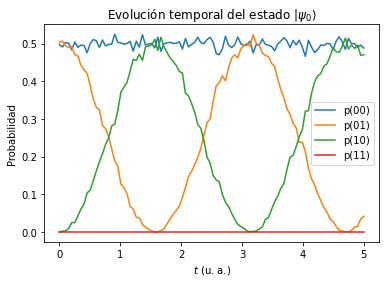

In [66]:
## Dibujamos p0 cno matplotlib
plt.title(r'Evolución temporal del estado $|\psi_0\rangle$')
plt.xlabel(r'$t$ (u. a.)')
plt.ylabel(r'Probabilidad')
plt.plot(tiempos,pdf[:,0],label=r'p(00)')
plt.plot(tiempos,pdf[:,1],label=r'p(01)')
plt.plot(tiempos,pdf[:,2],label=r'p(10)')
plt.plot(tiempos,pdf[:,3],label=r'p(11)')
plt.legend()
plt.show()

## Referencias

* Helgaker y otros. Molecular Elctronic Structure Theory. Wiley.
* Nielsen & Chuang. Quantum Computation and Quantum Information. Cambridge University Press, 2010.
* Barends y otros. (2015). Digital quantum simulation of fermionic models with a superconducting circuit. Nature Communications. DOI: 10.1038/ncomms8654
* Las Heras y otros. (2015). Fermionic models with superconducting circuits. EPJ Research. DOI 10.1140/epjqt/s40507-015-0021-5.